Исследуем данные о цене на недвижимость где-то в окрестности Сиэттла.
Для начала подключим табличку на языке программирования R:

In [60]:
data <- read.csv("kc_house_data.csv", header = TRUE, stringsAsFactors = FALSE)
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("flexsurv")) install.packages("flexsurv")
if (!require("fitdistrplus")) install.packages("fitdistrplus")
if (!require("dplyr")) install.packages("dplyr")
library(ggplot2)
library(flexsurv)
library(fitdistrplus)
library(dplyr)

Loading required package: flexsurv

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘flexsurv’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bdsmatrix’, ‘bbmle’, ‘fastGHQuad’, ‘RcppArmadillo’, ‘assertthat’, ‘deSolve’, ‘mstate’, ‘muhaz’, ‘mvtnorm’, ‘numDeriv’, ‘quadprog’, ‘rstpm2’, ‘statmod’




1. Предположим с каким вероятностным законом распределена цена. Для этого рассмотрим распределение под руги

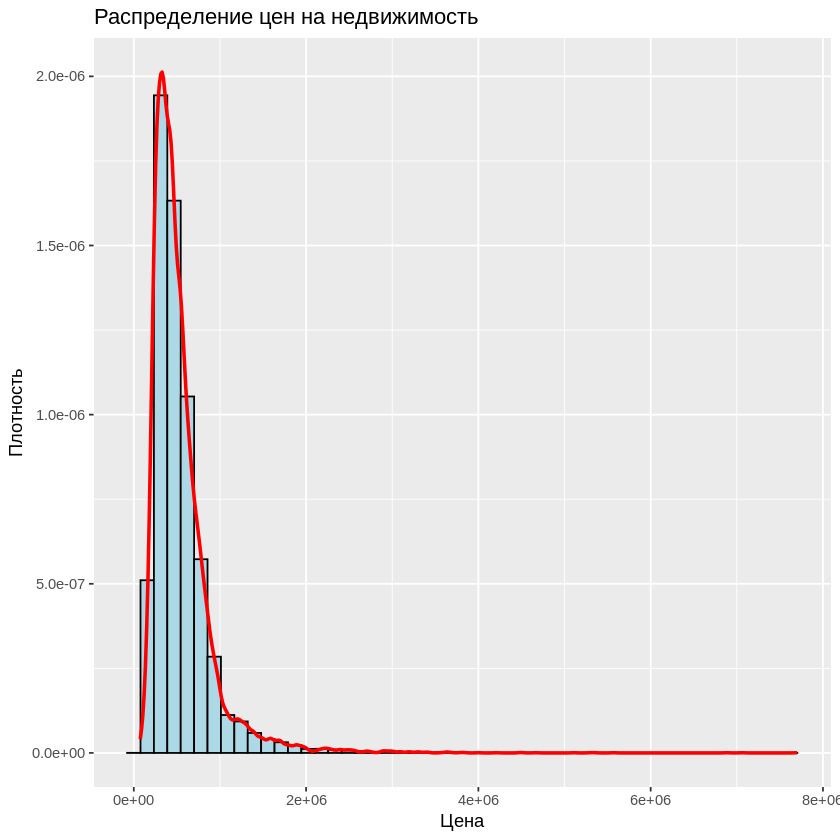

In [21]:
ggplot(data, aes(x = price)) +
  geom_histogram(aes(y = after_stat(density)), bins = 50, fill = "lightblue", color = "black") +
  geom_density(color = "red", linewidth = 1) +
  ggtitle("Распределение цен на недвижимость") +
  xlab("Цена") + ylab("Плотность")

Как мы видим, здесь наблюдается положительная асимметрия, причём довольно явная(с очень большим правым хвостом). Это может говорить нам о том, что в данном случае наблюдается логнормальное распределение(которое часто наблюдается в ценах на недвижимость) с σ = 10. Проверим это:

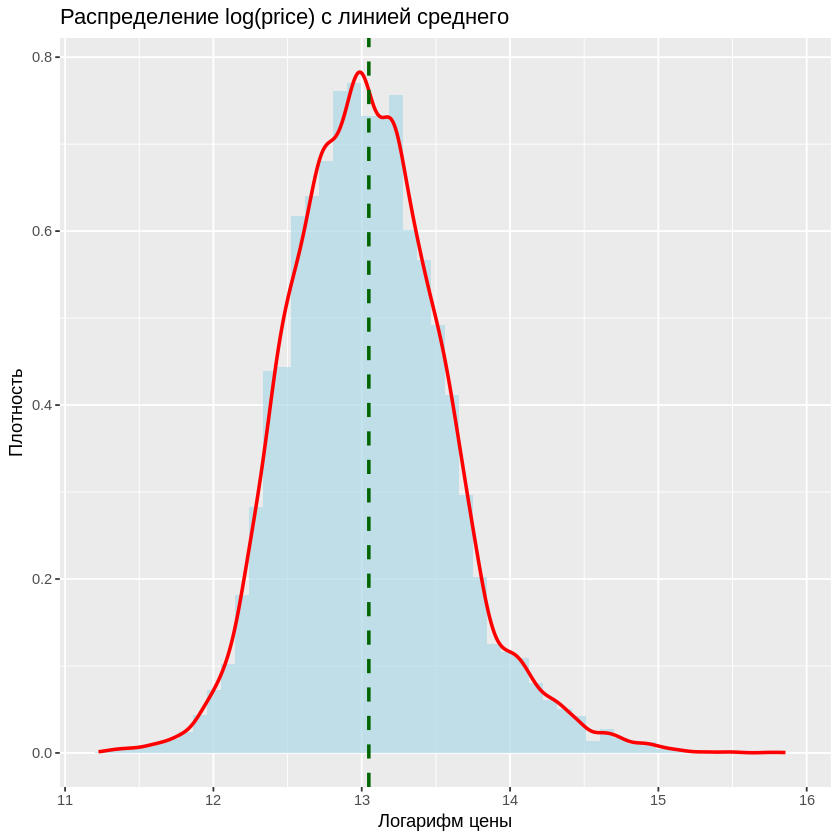

In [24]:
data$log_price <- log(data$price)
ggplot(data, aes(x = log_price)) +
  geom_histogram(aes(y = after_stat(density)), bins = 50, fill = "lightblue", alpha = 0.7) +
  geom_density(color = "red", linewidth = 1) +
  geom_vline(xintercept = mean(data$log_price), color = "darkgreen", linewidth = 1, linetype = "dashed") +
  ggtitle("Распределение log(цена) с линией симметричности") +
  xlab("Логарифм цены") + ylab("Плотность")


По визуальному анализу наблюдается симметрия относительно среднего. Но для убедительности проверим на критерии согласия Колмогорова(так как распределение непрерывное).\
Проверяем гипотезы: \
$H_0$: логарифмы цен подчиняются нормальному распределению. \
$H_1$: логарифмы цен не подчиняются нормальному распределению. (здесь и далее в пункте 1 будем использовать такие гипотезы по поводу нормального распределения)
Выберем стандартный уровень значимости для такого: $ \alpha $ = 0.05(здесь и далее во всём исследовании будем использовать такой параметр)

In [27]:
mu <- mean(data$log_price)
sigma <- sd(data$log_price)
ecdf_fun <- ecdf(data$price)
plnorm_custom <- function(x) plnorm(x, meanlog = mu, sdlog = sigma)
x <- sort(data$price)
D <- max(abs(ecdf_fun(x) - plnorm_custom(x)))
n <- length(x)
critical_value <- 1.36 / sqrt(n)
p_value_manual <- exp(-2 * (D * sqrt(n))^2)
cat("Статистика D =", D, "\n")
cat("Критическое значение =", critical_value, "\n")
cat("p-value =", p_value_manual, "\n")

Статистика D = 0.02598753 
Критическое значение = 0.009250845 
p-value = 2.097717e-13 


Но в нашей выборке присутствуют повторяющиеся значения, из-за чего критерий Колмогорова может давать неточности. Поэтому добавим немного шума к данным и повторим тест:

In [29]:
set.seed(123)
data$log_price_fixed <- jitter(data$log_price, amount = 0.0001)
data$price_fixed <- jitter(data$price, amount = 0.0001)
mu <- mean(data$log_price_fixed)
sigma <- sd(data$log_price_fixed)
ecdf_fun <- ecdf(data$price_fixed)
plnorm_custom <- function(x) plnorm(x, meanlog = mu, sdlog = sigma)
x <- sort(data$price_fixed)
D <- max(abs(ecdf_fun(x) - plnorm_custom(x)))
n <- length(x)
critical_value <- 1.36 / sqrt(n)
p_value_manual <- exp(-2 * (D * sqrt(n))^2)
cat("Статистика D =", D, "\n")
cat("Критическое значение =", critical_value, "\n")
cat("p-value =", p_value_manual, "\n")

Статистика D = 0.02598712 
Критическое значение = 0.009250845 
p-value = 2.099662e-13 


Ну и теперь мы с очень большой уверенностью можем сказать, что у нас нет никаких причин отвергать гипотезу $ H_1 $ о ненормальности распределения после логарифмирования, причём при любых разумных уровнях значимости(не только при числе 0.05). Для убедительности проверим с помощью готовой реализации теста Колмогорова:

In [30]:
mu_jittered <- mean(data$log_price_fixed)
sigma_jittered <- sd(data$log_price_fixed)
ks_test_jittered <- ks.test(data$log_price_fixed, "pnorm", mean = mu_jittered, sd = sigma_jittered)
print(ks_test_jittered)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data$log_price_fixed
D = 0.025912, p-value = 4.972e-13
alternative hypothesis: two-sided



Рассмотрим гамма-распределение. Для него будут такие же гипотезы:

In [56]:
data_jittered <- data_clean %>%
  mutate(price_jittered = jitter(price, amount = 0.001 * sd(price)))

ks_gamma_jittered <- ks.test(data_jittered$price_jittered, "pgamma",
                            shape = shape,
                            rate = rate)
print(ks_gamma_jittered)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_jittered$price_jittered
D = 0.061008, p-value < 2.2e-16
alternative hypothesis: two-sided



Как мы видим, и гамма-распределение также не подходит. Рассмотрим распределение Вейбулла:

Warning message in cov2cor(varcovar):
“diag(V) had non-positive or NA entries; the non-finite result may be dubious”
Warning message in sqrt(diag(varcovar)):
“NaNs produced”
Warning message in ks.test.default(data_clean$price, "pweibull", shape = fit_weibull$estimate["shape"], :
“ties should not be present for the one-sample Kolmogorov-Smirnov test”



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_clean$price
D = 0.07371, p-value < 2.2e-16
alternative hypothesis: two-sided


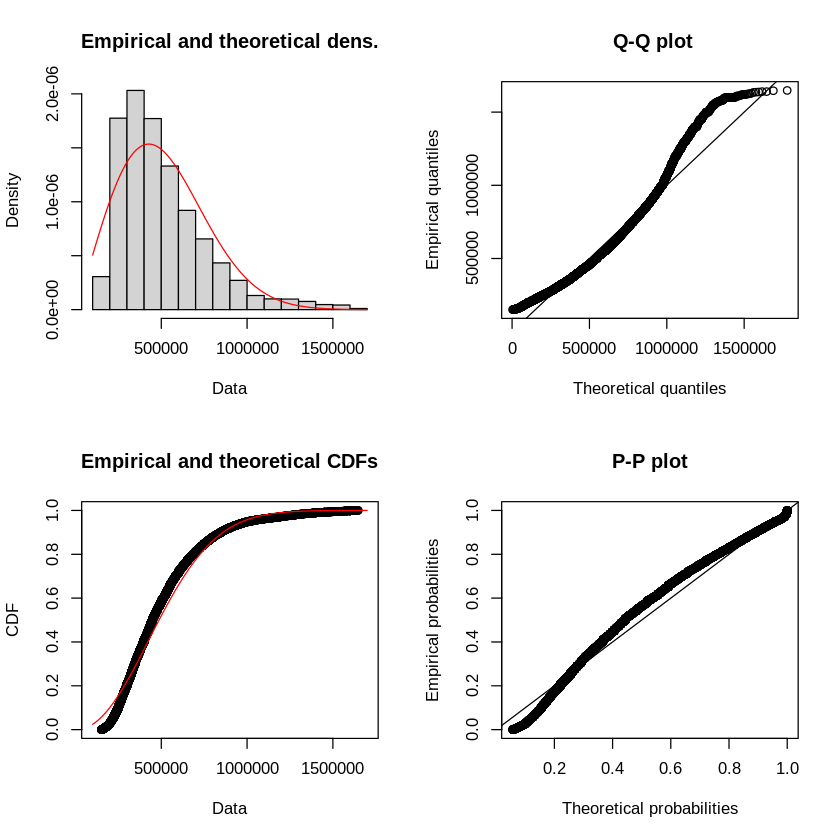

In [105]:
data_clean <- data_clean %>%
  filter(price > quantile(price, 0.001) &
         price < quantile(price, 0.999))
fit_weibull <- fitdist(data_clean$price, "weibull")
ks.test(data_clean$price, "pweibull",
       shape = fit_weibull$estimate["shape"],
       scale = fit_weibull$estimate["scale"])
plot(fit_weibull)

Распределение Вейбулла также не подходит. Теперь рассмотрим общее распределение гамма, также немного подправив данные:

In [108]:
data$price_jittered <- jitter(data$price, amount = 0.001 * sd(data$price))
fit_ggamma_jittered <- flexsurvreg(Surv(data$price_jittered) ~ 1, dist = "gengamma")
ks_result <- ks.test(data$price_jittered, "pgengamma",
                    mu = fit_ggamma_jittered$res["mu","est"],
                    sigma = fit_ggamma_jittered$res["sigma","est"],
                    Q = fit_ggamma_jittered$res["Q","est"])
print(ks_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data$price_jittered
D = 0.01353, p-value = 0.0007318
alternative hypothesis: two-sided



Так как D довольно низкий относительно других теоретических функций распределения, рассмотрим на графике для подтверждения(хоть у нас нет оснований отвергнуть гипотезу про не гамма-распределение, но всё же это распределение выглядит лучше других за счёт именно параметра D < 0.2).

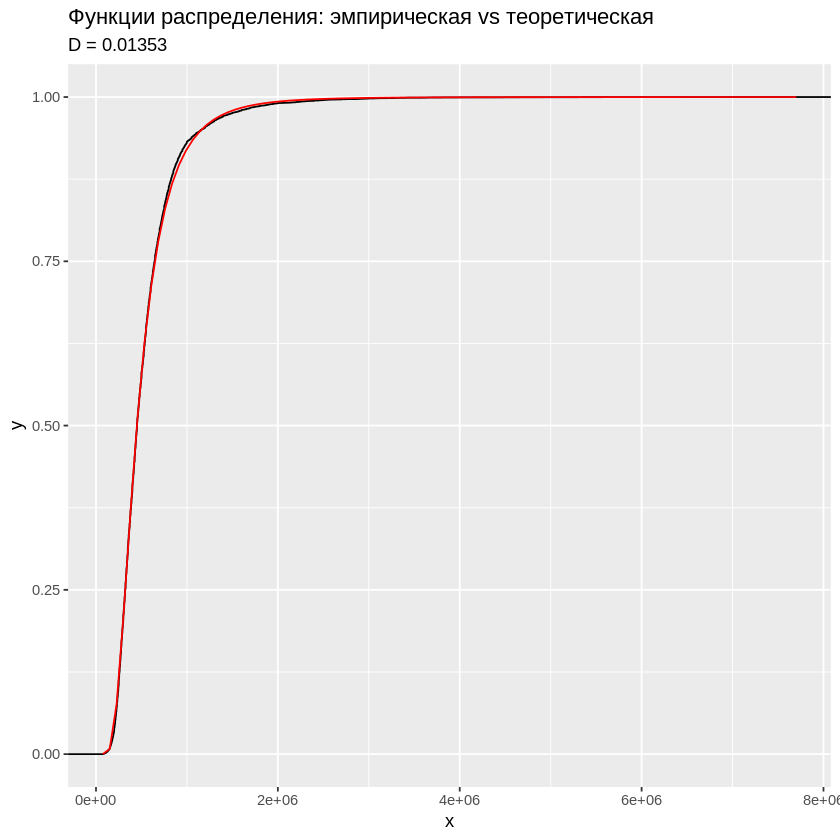

In [67]:
ggplot(data.frame(x = data$price), aes(x)) +
  stat_ecdf() +
  stat_function(fun = pgengamma,
                args = list(mu = fit_ggamma$res["mu","est"],
                           sigma = fit_ggamma$res["sigma","est"],
                           Q = fit_ggamma$res["Q","est"]),
                color = "red") +
  labs(title = "Функции распределения: эмпирическая и теоретическая",
       subtitle = paste("D =", round(ks_result$statistic, 5)))


Как видим на графике, функции почти равны и, учитывая небольшую статистику D, мы можем сказать что это лучшее теоретическое распределение из проверенных(мы рассмотрели самые подходящие к распределениям цен).

2. Теперь рассмотрим другую задачу. Рассмотрим гипотезу "цена на старый и новый фонд распределена одинаково". Старый фонд определим согласно следующим данным:"Согласно отчёту Housing Seattle, более 50% жилого фонда города было построено до 1960 года. Эти дома часто рассматриваются как часть "старого фонда", особенно в контексте программ обновления и сохранения жилья."([Источник](https://www.seattle.gov/documents/departments/seattleplanningcommission/housingseattlereport/housingseattleweb.pdf)).



Сделаем это разделение в данных:

In [73]:
data <- data %>%
  mutate(age_group = ifelse(yr_built < 1960, "old_fund", "new_fund"))


Теперь проверим гипотезу через f-test + t-test. \
$H_0$:
Распределения цен на недвижимость в старом и новом фонде одинаковы (однородны).

$H_1$: Распределения цен в старом и новом фонде различаются. \
ну и гипотезы про равенство дисперсий проверим через f-test:

In [95]:
data_old_fund <- data %>%
  filter(age_group == "old_fund")

data_new_fund <- data %>%
  filter(age_group == "new_fund")

var_old <- var(data_old_fund$price)
var_new <- var(data_new_fund$price)


F_stat <- max(var_old, var_new) / min(var_old, var_new)

n <- length(data_old_fund$price)
m <- length(data_new_fund$price)
df1 <- n - 1
df2 <- m - 1
F_critical <- qf(0.975, df1, df2)
p_value_F <- 2 * min(
  pf(F_stat, df1, df2),
  1 - pf(F_stat, df1, df2)
)
cat("p_value",format.pval(p_value_F))

p_value 0.24381

Как мы видим, p_value > 0.05, а значит дисперсии равны. Тогда мы можем применить t-test:

In [94]:

mean_old <- mean(data_old_fund$price)
mean_new <- mean(data_new_fund$price)
s_p_sq <- ((n-1)*var_old + (m-1)*var_new) / (n + m - 2)

t_stat <- (mean_old - mean_new) / sqrt(s_p_sq * (1/n + 1/m))
df_t <- n + m - 2


t_critical <- qt(0.975, df_t)


p_value_t <- 2 * pt(-abs(t_stat), df_t)
cat("p_value:",format.pval(p_value_t))

p_value: 1.0383e-05

Как мы видим, p < 0.05, а значит распределения цен различаются.

3. Теперь проверим гипотезу "при увеличении ”жилищной площади” растет и цена".

$H_0$: Коэффициент корреляции равен 0

$H_1$: Коэффициент корреляции не равен 0


Для этого посчитаем коэффициент Пирсона:

In [88]:
n <- length(data$sqft_living)
mean_x <- mean(data$sqft_living)
mean_y <- mean(data$price)
cov_xy <- sum((data$sqft_living - mean_x) * (data$price - mean_y)) / (n - 1)
var_x <- var(data$sqft_living)
var_y <- var(data$price)
r_pearson <- cov_xy / (sqrt(var_x) * sqrt(var_y))

cat("Коэффициент Пирсона:",r_pearson)

Коэффициент Пирсона: 0.7020351

Теперь проверим значимость корреляции(т.е проведём t-test): \


In [96]:
t_stat <- r_pearson * sqrt(n - 2) / sqrt(1 - r_pearson^2)
p_value <- 2 * pt(-abs(t_stat), df = n - 2)

cat("t-статистика:", t_stat, "\n")
cat("p-value:", format.pval(p_value))

t-статистика: 84.72782 
p-value: < 2.22e-16

Связь между площадью и ценой статистически значима на любом разумном уровне значимости, согласно p_value и t-статистики. А это значит что наш высокий коэффициент корреляции действительно существует, особенно при учёте того что у нас большая выборка => гипотеза верна(что действительно соответствует реальным данным в вопросе недвижимости)